## Table of Contents
1. [Data Visualizations](#section1)
2. [Evalution](#section2)
3. [Conclusion and Further Improvements](#section3)

## Data Visualizations <a class='anchor' id='section1'></a>

#### Imports

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, plot_precision_recall_curve, accuracy_score
%matplotlib inline

#### Setting up Data

In [2]:
lr = pd.read_csv('../data/lr_probs.csv')
rf = pd.read_csv('../data/rf_probs.csv')
knn = pd.read_csv('../data/knn_probs.csv')
dnn = pd.read_csv('../data/deep_probs.csv')

df = pd.concat([lr,rf,knn,dnn], axis = 1)
df.drop('Unnamed: 0', inplace = True, axis = 1)

In [57]:
loan = pd.read_csv('../data/loan_rf_features.csv')

In [59]:
X = pd.get_dummies(loan.drop(columns = ['loan_status']))
y = loan['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    stratify = y,
                                                    test_size= 0.2)


#### Creating dataframe with all scores

In [154]:
roc = []
precs = []
recs = []
pr_auc = []
accs = []
#For loop making lists of all scores
for c in df.columns:
    score = roc_auc_score(y_test, df[c])
    roc.append([c,score])
    
    prcs = precision_score(y_test, df[c].round())
    precs.append([c, prcs])
    
    rec = recall_score(y_test, df[c].round())
    recs.append([c, rec])
    
    precision, recall, _ = precision_recall_curve(y_test, df[c])
    
    p_r_auc = auc(recall, precision)
    pr_auc.append([c, p_r_auc])
    
    acc = accuracy_score(y_test, df[c].round())
    accs.append([c,acc])

#Making dataframes and merging
roc = pd.DataFrame(roc, columns = ['model', 'roc_score'])
precs = pd.DataFrame(precs, columns = ['model', 'precision_score'])
recs = pd.DataFrame(recs, columns = ['model', 'recall_score'])
pr_auc = pd.DataFrame(pr_auc, columns = ['model', 'pr_auc'])
accs = pd.DataFrame(accs, columns = ['model', 'accuracy_score'])

scores = roc.merge(precs).merge(recs).merge(pr_auc).merge(accs)
    
scores['model'] = ['logistic_regression', 'random_forest', 'k_nearest', 'deep_neural_net']


In [155]:
scores

,model,roc_score,precision_score,recall_score,pr_auc,accuracy_score
0,logistic_regression,0.945777,0.791151,0.685354,0.796784,0.901520
1,random_forest,0.950311,0.761255,0.772534,0.824863,0.906651
2,k_nearest,0.915068,0.786066,0.563450,0.756691,0.882775
3,deep_neural_net,0.950571,0.759589,0.773754,0.823277,0.906374


#### Plotting PR-ROC Curves for all models

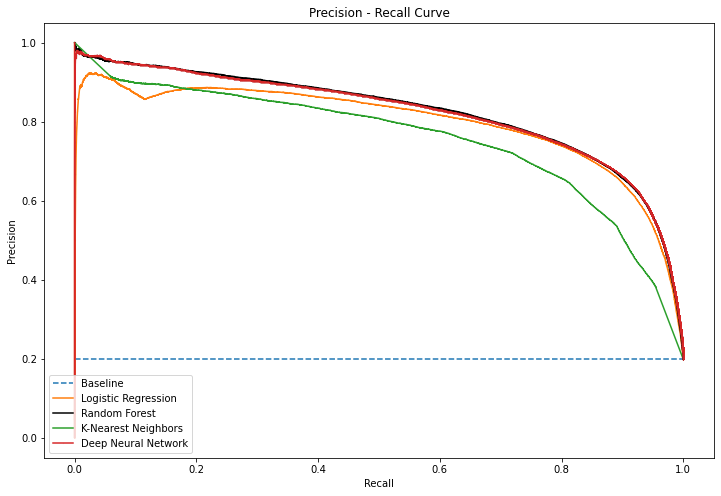

In [153]:
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.figure(figsize = (12,8))
plt.plot( [no_skill, no_skill], linestyle = '--', label = 'Baseline')

precision, recall, _ = precision_recall_curve(y_test, df['lr_probs'])
plt.plot(recall, precision, marker = '.', label = 'Logistic Regression', markersize = 0.01)

precision, recall, _ = precision_recall_curve(y_test, df['rf_probs'])
plt.plot(recall, precision, marker = '.', label = 'Random Forest', markersize = 0.01, color = 'black')

precision, recall, _ = precision_recall_curve(y_test, df['knn_probs'])
plt.plot(recall, precision, marker = '.', label = 'K-Nearest Neighbors', markersize = 0.01)

precision, recall, _ = precision_recall_curve(y_test, df['deep_probs'])
plt.plot(recall, precision, marker = '.', label = 'Deep Neural Network', markersize = 0.1)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve')
plt.legend(loc = 'lower left')

plt.savefig('../images/pr_curve.png')
plt.show();

## Evaluation <a class='anchor' id='section2'></a>

In the interest of minimizing the number of false negatives, we are looking to evluate our models based upon their Precision-Recall AUC score, while also taking the recall score into account. We want to minimize the number of false negatives as false negatives indicate a loan that is predicted to be paid in full, but instead ends up in default. Due to the case that our data has imbalanced classes, we cannot use our accuracy score to judge our models due to the accuracy paradox. The accuracy paradox, in short, basically conveys we cannot use accuracy as a scale of effectiveness due to the fact that choosing our majority class as a prediction for all predictions would still lead us to a high accuracy score. In this case, we could guess that all loans would be paid in full and we would be correct 80% of the time. 

In looking at our models, the Random Forest model, with GridSearchCV-tuned hyperparameters and feature selection, performed the best. It only performed slightly better than our Deep Neural Network and that is by 0.0015 in terms of the Precision-Recall AUC score. We can see this when looking at all of our models shown on the Precision-Recall Curve figure above. Random Forest and Deep Neural Network are almost identical and the Logistic Regression model falls shortly behind. In addition to being the worst model, the K-Nearest Neighbors classifier also took the longest to train due to its matrix multiplication stored in local memory. K-Nearest Neighbors models do not perform too well with large datasets such as ours, but in future models, we hope to adjust the number of neighbors more as KNN models generally do well with binary classification. The Random Forest model also had the closest precision and recall scores, but overall the Deep Neural Network had the highest recall score, but by a very very miniscule margin. Interestingly, our Deep Neural Network had a >90% recall rate when we reduced the number of neurons, but at the expense of our accuracy as well as precision. The precision score would drop to around ~60%. Despite this fact, we use the PR-AUC score to judge our models due to the fact that it summarizes the skill of our model across thresholds. Higher scores for both our precision and recall shows that our classifier returns accurate results while also returning a majority of all positive results (minority class - loan default). However, the difference between the Random Forest and DNN models is marginal and both would perform about equally in terms of accuracy as well. 

In comparison to our baseline model, the Random Forest model is a significant improvement. The recall score and precision score for our baseline model, which was calculated using a DummyClassifier, was ~20%. With a recall score of 77%, we can say that our model is effective at its job. The accuracy score for the Random Forest model was also ~90% which outperforms the baseline model by around 20% as the baseline is at ~68%. The DummyClassifier works by generating guesses on the binary prediction while taking into consideration the class distribution. Even if accuracy score was used as an evaluation metric, our model would still perform better than by simply guessing the majority class. 

## Conclusion and Further Improvements <a id='section3'></a>

In this study, we aimed to create and demonstrate a model that can aid in loan default prediction. We built supervised learning models that generate binary classification predictions using features that are present in a traditional loan screening. With this, we can efficientaly classify loan applicants in advance and prevent financial loss without the financial rents spent by traditional financial institutions to satisfy their risk profile. With growing demand for P2P lending as well as the integration of financial technologies into many storefronts, our study should benefit many investors as less defaults will occur in loan screening with our model. 

Our Random Forest classifier performed the best when observing the Precision-Recall AUC score and with our Random Forest model, we can also extract feature importance. We found that FICO scores, interest rate, debt-to-income-ratio, installment size, and average current balance were important in our models. We also examined the coefficients from our logistic regression model since it still performed well, although with a much worse recall score. In terms of accuracy, it still ranked well  with a 90.1% accuracy score, so we may derive some explanatory power. Increases in FICO score led to a huge decrease in likelihood of default (94%), while annual income also saw the same relationship albeit at 12%. Increases in debt-to-income ratio, installment, and term saw increases in likelihood of default.

With this being a work in progress, we hope to improve our model by implementing several strategies with our data, modeling, and further studies. Due to the case that we have imbalanced classes, we will implement random undersampling as well as SMOTE with our minority class. Our data set is fairly large so it does not seem out of this world to undersample our majority class as we had ~1 million samples of this specified class. We would also look to implement probability tuning and threshold tuning to extract strong effectiveness out of our models in terms of our evaluation metrics (recall and precision-recall area-under-the-curve score). In addition to this, we were only able to model using 4 different algorithms, but seeing how our ensemble model (Random Forest) performed, we will also look to model using XGBoost and Extra Trees. Support Vector Machine classifiers also perform well due to the usage of kernel tricks but generally perform better on sparse data. There have been strategies created to aid in SVMs modeled on large data sets, specifically the minimum enclosing ball clustering method. We can also improve our models by reducing the complexity of our data such as removing unnecessary categorical features, as many of them were insignficant in the predictions of our models. We can also reduce the number of correlated features and deploy Recursive Feature Elimination to aid in our linear algorithms. 

